# Projet 7 : Implémentez un modèle de scoring

## NB C : Essais de classification binaire et tracking via MLFlow



- <a href="#C1"> 1. Importation des données</a>

- <a href="#C2"> 2. Pre-processing </a>

- <a href="#C3"> 3. Entraînement du modèle et score métier </a>

- <a href="#C4"> 4. Score sur le jeu test </a>
  -  <a href="#C41"> 4.1 Matrice de confusion et rapport de classification <a>
  -  <a href="#C42"> 4.2 Courbe ROC <a>

- <a href="#C5"> 5. Feature importance </a>

- <a href="#C6"> 6. Téléchargement des expériences MLFlow </a>



In [46]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_
import joblib
import os

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders --quiet
!pip install mlflow==2.5.0 --quiet
!pip install imbalanced-learn --quiet
!pip install lightgbm --quiet
!pip install shap --quiet
!pip install xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00


In [225]:
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler,  StandardScaler, FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from category_encoders import *
set_config(display="diagram")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# <a name="C1"> 1. Importation des données</a>

In [3]:
it = 2 # 1, 2 première itération pour le choix des features
selected_features = [#'GENRE',
                     'PROPRIETAIRE', 'NBRE_ENFANT',
       'ANCIENNETE_CREDIT', 'CHARGES_ANNUEL', 'REVENUS_TOT', 'MONTANT_CREDIT',
       'OCCUPATION', 'CC_RATIO_CREDIT', 'NIVEAU_ETUDE', 'AGE',
       'ANCIENNETE_EMPLOI', 'SCORE_REGION', 'HEURE_APP', 'SECTEUR_ACTIVITE',
       'SCORE_2_EXT', 'RATIO_ENDETT(%)', 'NBRE_CONTRAT_ACTIFS',
       'NBRE_J_RETARD', 'POS_PROGRESS_MAX_MIN', 'CC_NOMBRE_RETRAIT_MOYEN',
       'CB_SOMME_DUES_RETARD']
df = pd.read_csv('/content/client_train_db.csv',
                 usecols = selected_features,
                 dtype={'GENRE': 'object'
                      })
id_clients = pd.read_csv('/content/client_train_db.csv',
                 usecols = ['SK_ID_CURR'],
                 dtype={'SK_ID_CURR' : 'object',
                      })
y_ = pd.read_csv('/content/client_train_db.csv',
                 usecols = ['TARGET'],
                dtype={'TARGET' :  'object'
                      })
df.head()

,PROPRIETAIRE,NBRE_ENFANT,REVENUS_TOT,MONTANT_CREDIT,OCCUPATION,NIVEAU_ETUDE,AGE,ANCIENNETE_EMPLOI,SCORE_REGION,HEURE_APP,...,SCORE_2_EXT,RATIO_ENDETT(%),CC_NOMBRE_RETRAIT_MOYEN,POS_PROGRESS_MAX_MIN,CB_SOMME_DUES_RETARD,CC_RATIO_CREDIT,NBRE_CONTRAT_ACTIFS,NBRE_J_RETARD,CHARGES_ANNUEL,ANCIENNETE_CREDIT
0,Y,0,202500.0,406597.5,Working,BAC,26,2,2,10,...,0.262949,12.2,0.0,75.000000,0.0,0.0,3.0,0.0,24700.5,47.0
1,N,0,270000.0,1293502.5,State servant,ENS_SUP,47,3,1,11,...,0.622246,13.2,0.0,91.666667,0.0,0.0,1.0,0.0,35698.5,77.0
2,Y,0,67500.0,135000.0,Working,BAC,53,1,2,9,...,0.555912,10.0,0.0,100.000000,0.0,0.0,0.0,0.0,6750.0,27.0
3,Y,0,135000.0,312682.5,Working,BAC,53,8,2,17,...,0.650442,22.0,0.0,75.000000,0.0,0.0,2.0,0.0,29686.5,19.0
4,Y,0,121500.0,513000.0,Working,BAC,55,8,2,11,...,0.322738,18.0,0.0,45.833333,0.0,0.0,2.0,1.0,21865.5,77.0


In [4]:
y_.head()

,TARGET
0,1
1,0
2,0
3,0
4,0


In [5]:
y_['TARGET'].unique()

array(['1', '0'], dtype=object)

# <a name="C1"> 2. Pre-processing </a>



Quatre options :


0.   Je garde le datasets tel qu'il est
1.   Sous-échantillonnage
2.   Sur-échantillonnage (SMOTE)
3.   Class-weighting (fais dans le cas 0)


In [377]:
option = int(input("Entrer l'option d'échantillonnage 'option': \n 0 pour le class-weighting, 1 pour un sous-échantillonage et 2 pour la méthode SMOTE "))
model = input("Entrer le modèle à tester: ex : Logistic Regression, LDA,  ")

print("Option:", int(option))
print("Model:", model)


Entrer l'option d'échantillonnage 'option': 
 0 pour le class-weighting, 1 pour un sous-échantillonage et 2 pour la méthode SMOTE 3
Entrer le modèle à tester: ex : Logistic Regression, LDA,  LightGBM
Option: 3
Model: LightGBM


In [378]:
df.columns

Index(['PROPRIETAIRE', 'NBRE_ENFANT', 'REVENUS_TOT', 'MONTANT_CREDIT',
       'OCCUPATION', 'NIVEAU_ETUDE', 'AGE', 'ANCIENNETE_EMPLOI',
       'SCORE_REGION', 'HEURE_APP', 'SECTEUR_ACTIVITE', 'SCORE_2_EXT',
       'RATIO_ENDETT(%)', 'CC_NOMBRE_RETRAIT_MOYEN', 'POS_PROGRESS_MAX_MIN',
       'CB_SOMME_DUES_RETARD', 'CC_RATIO_CREDIT', 'NBRE_CONTRAT_ACTIFS',
       'NBRE_J_RETARD', 'CHARGES_ANNUEL', 'ANCIENNETE_CREDIT'],
      dtype='object')

In [379]:
y = y_['TARGET']

In [380]:
y.unique()

array(['1', '0'], dtype=object)

In [381]:
len(y[y == '1'])

24747

In [382]:
y[y == '1']

0         1
26        1
40        1
42        1
81        1
         ..
306649    1
306676    1
306682    1
306690    1
306710    1
Name: TARGET, Length: 24747, dtype: object

In [383]:
model

'LightGBM'

In [384]:
len(y)

306712

In [385]:
if option == 0:
    Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(df, y, train_size=0.8, random_state=42, stratify = y)
elif option == 1:
    # Option 1 :  Sous-échantillonnage, Je récupère tous les '1' et je choisie un échantillon d'individu '0' de la même taille pour former un nouevau
    # dataset concaténé.
    len_target = len(y[y == '1'])
    y_1 = y[y == '1']
    ind_y1 = y[y == '1'].index
    y_0 = y[y == '0'].sample(len_target, random_state=42)
    ind_y0 = y_0.index
    y_resampled = pd.concat([y_1, y_0])
    ind_tot= y_resampled.index
    Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(df.loc[ind_tot], y_resampled, train_size=0.8, random_state=42,
                                                                    stratify =y_resampled)
elif option == 2:
    # Option 2 : Méthode mixte de sur-échantillonage de type smote et de sous-échantillonage, la méthode smote
    # sera appliqué dans la recherche de grille durant la valisation croisée pour éviter le data leakage
    len_target = len(y[y == '1'])
    y_1 = y[y == '1']
    ind_y1 = y[y == '1'].index
    y_0 = y[y == '0'].sample(int(1.5*len_target), random_state=42)
    ind_y0 = y_0.index
    y_resampled = pd.concat([y_1, y_0])
    ind_tot= y_resampled.index
    Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(df.loc[ind_tot], y_resampled,
                                                                    train_size=0.8, random_state=42, stratify =y_resampled)
    smote = SMOTE(sampling_strategy='auto', random_state=42)
elif option ==3:
    len_target = len(y[y == '1'])
    y_1 = y[y == '1']
    ind_y1 = y[y == '1'].index
    y_0 = y[y == '0'].sample(int(3*len_target), random_state=42)
    ind_y0 = y_0.index
    y_resampled = pd.concat([y_1, y_0])
    ind_tot= y_resampled.index
    Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(df.loc[ind_tot], y_resampled, train_size=0.8, random_state=42,
                                                                    stratify =y_resampled)


In [386]:
len_target = len(y[y == '1'])
len_non_target = len(y[y == '0'])
class_weight_majority = len(y) / (len_non_target)
class_weight_minority = len(y) / (len_target)
class_weights = {'0': class_weight_majority, '1': class_weight_minority}


# Ma liste de modèle
models_dict = {'Dummy': [DummyClassifier(), 'non',
                         {'strategy': ['stratified', 'uniform'],
                          'random_state': [42],
                         }, None], #Le troisième élément représente l'option de feat importance
               'Logistic Regression': [LogisticRegression(), 'oui', #Oui car dans le calcul de la fonction d'hypothèse la fonction logistique est
                            #foncton de la combinaison linaire des ppoids et du vecteur x de l'individu. Si toutes les composantes de x ne sont pas mis
                            #à la même échelle certaines features auront d'avantage de poids que d'autre.
                             {'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                              'class_weight' : ['balanced', None],'penalty' : ['l2']
                              } , 'coeff'],
               'LDA' :  [LinearDiscriminantAnalysis(), 'oui',
                {'solver' : ['svd','lsqr'],#'eigen'],
                 'n_components' : [1]
                 } , 'coeff'],
               'Naive Bayes': [GaussianNB(), 'non',
                {'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]}, 'shap', 'other'],
               'LightGBM': [LGBMClassifier(objective='binary', metric='binary_logloss'), 'non',
                 {'learning_rate': [0.4, 0.5, 0.6],#0.7, 0.3, 0.1, 0.08,0.01, 0.001],
                  'max_depth': [3], #2, 4, 5, 7, 10, 20
                  'n_estimators': [140,150,160],#[10, 50, 70,100, 200, 250
                  'random_state': [42],
                  'class_weight': [#None,
                                   class_weights]
                 }, 'shap', 'tree'],
               'Decision Trees': [DecisionTreeClassifier(), 'non',
                       {'criterion': ['gini', 'entropy'],
                        'max_depth': [None, 3, 4, 5], #autre valeurs testé 100, 50, 20, 10
                        #'max_features': ['auto', 'sqrt', 'log2', None],
                        'class_weight': [None, 'balanced'],
                        'splitter': ['best', 'random'],
                        'random_state': [42]
                       }, 'shap', 'tree'],

}


In [387]:
models_dict[model][2]

{'learning_rate': [0.4, 0.5, 0.6],
 'max_depth': [3],
 'n_estimators': [140, 150, 160],
 'random_state': [42],
 'class_weight': [{'0': 1.0877662121185254, '1': 12.393906332080656}]}

In [388]:
len(df)

306712

In [389]:
#### Fonctions ----------------------------
from sklearn.preprocessing import FunctionTransformer


# Calcul de la fréquence d'occurence pour le secteur d'activité
freq_by_org_type = df['SECTEUR_ACTIVITE'].value_counts(normalize=True).to_dict()
def frequency_encode(x):
    return x.replace(freq_by_org_type)

# Creation du FunctionTransformer pour la fréquence d'occurence par secteur d'activité
freq_encoder = FunctionTransformer(frequency_encode)

cat_features = df.dtypes[df.dtypes == 'object'].index.tolist()
cat_features = [feature for feature in cat_features if feature not in ['SK_ID_CURR', 'TARGET']]
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()


####--------- Les transformations
OneHot_transformer = OneHotEncoder(use_cat_names= True)
#target_transformer = TargetEncoder(smoothing=0.2) data leakage et résultat imprévisible

####---------Création de mon pipeline
if models_dict[model][1] == 'oui':
    # Scale features and handle skewed distributions
    numeric_transformer = MinMaxScaler()
    preprocessor = ColumnTransformer(transformers=[
        ('oneHot', OneHot_transformer, [#'GENRE',
                                        'PROPRIETAIRE', 'NIVEAU_ETUDE' , 'OCCUPATION']),
        #('target', target_transformer, cat_features[2]),
        ('frequency', freq_encoder, ['SECTEUR_ACTIVITE']),  # Add the Frequency Encoder here
        ('numeric', numeric_transformer, num_features),
        #('log_transform', FunctionTransformer(log_transform, validate=False), log_feature)
    ], remainder='passthrough')
else:
    # Do not apply MinMaxScaler but still include the log transformation
    preprocessor = ColumnTransformer(transformers=[
        ('oneHot', OneHot_transformer, [#'GENRE',
                                        'PROPRIETAIRE', 'NIVEAU_ETUDE' ,'OCCUPATION']),
        #('target', target_transformer, cat_features[2]),
        ('frequency', freq_encoder, ['SECTEUR_ACTIVITE']),  # Add the Frequency Encoder here
    ], remainder='passthrough')

In [390]:
freq_by_org_type

{'Business Entity': 0.27488979889929316,
 'Inactive': 0.1799603536868463,
 'Self-Employed and Professional Services': 0.127151855812619,
 'Other Categories': 0.11879222201935366,
 'Industry and Trade': 0.09309058660893607,
 'Government and Public Services': 0.07581379274368137,
 'Education': 0.055641774694175646,
 'Healthcare and Medicine': 0.0364054878843997,
 'Utilities and Services': 0.01647799890450977,
 'Hospitality and Entertainment': 0.011678708364850413,
 'Financial and Insurance': 0.010097420381334933}

In [391]:
models_dict[model][0]

LGBMClassifier(metric='binary_logloss', objective='binary')

In [392]:
Xtrain

,PROPRIETAIRE,NBRE_ENFANT,REVENUS_TOT,MONTANT_CREDIT,OCCUPATION,NIVEAU_ETUDE,AGE,ANCIENNETE_EMPLOI,SCORE_REGION,HEURE_APP,...,SCORE_2_EXT,RATIO_ENDETT(%),CC_NOMBRE_RETRAIT_MOYEN,POS_PROGRESS_MAX_MIN,CB_SOMME_DUES_RETARD,CC_RATIO_CREDIT,NBRE_CONTRAT_ACTIFS,NBRE_J_RETARD,CHARGES_ANNUEL,ANCIENNETE_CREDIT
54982,Y,0,202500.0,592560.0,Working,BAC,44,3,3,7,...,0.260241,19.8,0.0,16.666667,0.0,0.0,1.0,0.291667,27403.470,23.0
251613,Y,0,157500.0,540000.0,Working,BAC,52,6,2,10,...,0.444011,16.6,0.0,91.666667,0.0,0.0,3.0,0.063492,26109.000,67.0
187344,N,0,4500000.0,835380.0,Working,BAC,52,9,2,13,...,0.748822,0.9,0.0,100.000000,0.0,0.0,0.0,1.142857,-445286.790,20.0
108134,Y,0,108000.0,254700.0,Pensioner,BAC,62,0,2,10,...,0.374100,18.6,0.0,83.333333,0.0,0.0,1.0,10.941620,-77006.880,85.0
244680,Y,0,135000.0,1219437.0,Working,BAC,39,1,2,12,...,0.536347,38.4,0.0,100.000000,0.0,0.0,3.0,0.000000,51795.000,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70376,Y,0,247500.0,640080.0,Commercial associate,ENS_SUP,33,1,1,17,...,0.761896,12.1,0.0,58.333333,0.0,0.0,1.0,0.730392,29970.000,93.0
225338,N,3,157500.0,1350000.0,Working,BAC,38,5,2,16,...,0.452675,25.1,0.0,100.000000,0.0,0.0,1.0,0.000000,39604.500,36.0
17531,N,1,112500.0,314100.0,Working,BAC,30,2,2,13,...,0.456177,14.7,0.0,100.000000,0.0,0.0,0.0,0.000000,16573.500,18.0
284960,Y,0,135000.0,450000.0,Working,BAC,34,12,2,17,...,0.610150,9.3,0.0,33.333333,0.0,0.0,1.0,0.250000,17933.220,34.0


In [393]:
#Vérification du feature engineering
ct = preprocessor.fit(Xtrain,ytrain)
ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('oneHot', OneHotEncoder(use_cat_names=True),
                                 ['PROPRIETAIRE', 'NIVEAU_ETUDE',
                                  'OCCUPATION']),
                                ('frequency',
                                 FunctionTransformer(func=<function frequency_encode at 0x7a0b20c3f010>),
                                 ['SECTEUR_ACTIVITE'])])

In [394]:
import joblib

# Importation du pré-traitement.
joblib.dump(ct,'preprocessing_2.pkl')

['preprocessing_2.pkl']

In [395]:
X_new_transformed = preprocessor.transform(Xtrain)
X_new_transformed

,oneHot__PROPRIETAIRE_Y,oneHot__PROPRIETAIRE_N,oneHot__NIVEAU_ETUDE_BAC,oneHot__NIVEAU_ETUDE_ENS_SUP,oneHot__NIVEAU_ETUDE_COLLEGE,oneHot__OCCUPATION_Working,oneHot__OCCUPATION_Pensioner,oneHot__OCCUPATION_Commercial associate,oneHot__OCCUPATION_State servant,oneHot__OCCUPATION_Maternity leave,...,remainder__SCORE_2_EXT,remainder__RATIO_ENDETT(%),remainder__CC_NOMBRE_RETRAIT_MOYEN,remainder__POS_PROGRESS_MAX_MIN,remainder__CB_SOMME_DUES_RETARD,remainder__CC_RATIO_CREDIT,remainder__NBRE_CONTRAT_ACTIFS,remainder__NBRE_J_RETARD,remainder__CHARGES_ANNUEL,remainder__ANCIENNETE_CREDIT
54982,1,0,1,0,0,1,0,0,0,0,...,0.260241,19.8,0.0,16.666667,0.0,0.0,1.0,0.291667,27403.470,23.0
251613,1,0,1,0,0,1,0,0,0,0,...,0.444011,16.6,0.0,91.666667,0.0,0.0,3.0,0.063492,26109.000,67.0
187344,0,1,1,0,0,1,0,0,0,0,...,0.748822,0.9,0.0,100.000000,0.0,0.0,0.0,1.142857,-445286.790,20.0
108134,1,0,1,0,0,0,1,0,0,0,...,0.374100,18.6,0.0,83.333333,0.0,0.0,1.0,10.941620,-77006.880,85.0
244680,1,0,1,0,0,1,0,0,0,0,...,0.536347,38.4,0.0,100.000000,0.0,0.0,3.0,0.000000,51795.000,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70376,1,0,0,1,0,0,0,1,0,0,...,0.761896,12.1,0.0,58.333333,0.0,0.0,1.0,0.730392,29970.000,93.0
225338,0,1,1,0,0,1,0,0,0,0,...,0.452675,25.1,0.0,100.000000,0.0,0.0,1.0,0.000000,39604.500,36.0
17531,0,1,1,0,0,1,0,0,0,0,...,0.456177,14.7,0.0,100.000000,0.0,0.0,0.0,0.000000,16573.500,18.0
284960,1,0,1,0,0,1,0,0,0,0,...,0.610150,9.3,0.0,33.333333,0.0,0.0,1.0,0.250000,17933.220,34.0


# <a name="C3"> 3. Entraînement du modèle et score métier </a>

In [396]:
from sklearn.metrics import make_scorer, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def recall_seuil(y_true, y_prob):
    y_pred = ((y_prob >= threshold).astype(int)).astype(str)
    return recall_score(y_true, y_pred,  pos_label = '1')

def precision_seuil(y_true, y_prob):
    y_pred = ((y_prob >= threshold).astype(int)).astype(str)
    return precision_score(y_true, y_pred,  pos_label = '1')

def fonction_cout(y_true, y_prob):
    y_pred = ((y_prob >= threshold).astype(int)).astype(str)
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # Faux négatifs
    fp = cm[0, 1]  # Faux positifs
    cost = 10*fn + fp
    return cost


In [397]:
threshold = float(input("Entrer le seuil de classification à tester :  "))

Entrer le seuil de classification à tester :  0.5


In [398]:
from imblearn.pipeline import make_pipeline
cv = 10

#threshold = 0.4 # 0.4, 0.42, 0.43, 0.2

score = {'accuracy': 'accuracy',
         #'precision': metrics.make_scorer(precision_score, pos_label='1'),
         #'recall' : metrics.make_scorer(recall_score, pos_label='1'),
         'roc_auc' : metrics.make_scorer(roc_auc_score, needs_proba=True),
         'recall': metrics.make_scorer(recall_seuil, needs_proba=True),
         'precision': metrics.make_scorer(precision_seuil, needs_proba=True),
         'score_metier': metrics.make_scorer(fonction_cout, greater_is_better=False, needs_proba=True),
         }

param_grid = models_dict[model][2]
estimator = models_dict[model][0]

if option == 2:
  Pipe_smote = make_pipeline(
      smote,
      models_dict[model][0])
  id_model = str(models_dict[model][0]).split('(')[0].lower()
  param_grid_bis= {
        id_model+'__' + k: v for k, v in param_grid.items()
    }
  Pipe_0 = make_pipeline(
        preprocessor,
        smote,
        model_selection.GridSearchCV(
            estimator=Pipe_smote,
            param_grid=param_grid_bis,
            cv=cv,
            scoring=score,
            refit='score_metier',
            error_score='raise',
            n_jobs=-1
        ))
else :
  Pipe_0 = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_'+model, model_selection.GridSearchCV(estimator=estimator,
                                        param_grid=param_grid,
                                        cv=cv,
                                        scoring=score,
                                        refit='score_metier',
                                        error_score='raise',
                                        n_jobs=-1))])

In [399]:
if option == 2: #vérification
  print(param_grid_bis)
else :
  print(param_grid)

{'learning_rate': [0.4, 0.5, 0.6], 'max_depth': [3], 'n_estimators': [140, 150, 160], 'random_state': [42], 'class_weight': [{'0': 1.0877662121185254, '1': 12.393906332080656}]}


In [400]:
id_model

'lgbmclassifier'

In [401]:
import mlflow
import mlflow.sklearn
import time

# Set the experiment name for MLflow
experiment_name = 'Classification_'+model.split()[0]

# Start the MLflow experiment

mlflow.set_experiment(experiment_name)
mlflow.start_run()

ls_features = X_new_transformed.columns.tolist()
ls_features_string = ', '.join(ls_features)
mlflow.log_text(ls_features_string, "features_list.txt")

print("Starting model training...")
start_time = time.time()  # Record the start time

# Fit the pipeline with GridSearchCV
Pipe_0.fit(Xtrain, ytrain)

end_time = time.time()  # Record the end time
print("Model training completed in {:.2f} seconds.".format(end_time - start_time))


Starting model training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19798, number of negative: 59392
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2670
[LightGBM] [Info] Number of data points in the train set: 79190, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.791584 -> initscore=1.334500
[LightGBM] [Info] Start training from score 1.334500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [402]:
Pipe_0

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['PROPRIETAIRE',
                                                   'NIVEAU_ETUDE',
                                                   'OCCUPATION']),
                                                 ('frequency',
                                                  FunctionTransformer(func=<function frequency_encode at 0x7a0b20c3f010>),
                                                  ['SECTEUR_ACTIVITE'])])),
                ('grid_search_LightGBM',
                 GridSearchCV(cv=10, error_score='raise',
                              es...
                                          'n_estimators': [140, 150, 160],
                                          'random_state': [42]},
                              refit='score_metier',
                              scoring={'accuracy': 'accuracy',
                                       'precision': make_scorer(precision_seuil, needs_proba=True),
                                       'recall': make_scorer(recall_seuil, needs_proba=True),
                                       'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
                                       'score_metier': make_scorer(fonction_cout, greater_is_better=False, needs_proba=True)}))])

In [403]:
#TRACKING
if option !=2 :
  mlflow.log_params(Pipe_0['grid_search_' + model].best_params_)
  best_index = Pipe_0['grid_search_' + model].best_index_
  cv_results = Pipe_0['grid_search_' + model].cv_results_
  metrics_to_log = {key: value[best_index] for key, value in cv_results.items() if key.startswith('mean_test_')}
  metrics_to_log['data_sampling'] = option
  metrics_to_log['threshold'] = threshold
  mlflow.log_metrics(metrics_to_log)
else :
  mlflow.log_params(Pipe_0['gridsearchcv'].best_params_)
  best_index = Pipe_0['gridsearchcv'].best_index_
  cv_results = Pipe_0['gridsearchcv'].cv_results_
  metrics_to_log = {key: value[best_index] for key, value in cv_results.items() if key.startswith('mean_test_')}
  metrics_to_log['threshold'] = threshold
  metrics_to_log['data_sampling'] = option
  mlflow.log_metrics(metrics_to_log)

In [404]:
metrics_to_log

{'mean_test_accuracy': 0.3606894809950752,
 'mean_test_roc_auc': 0.7214686189451933,
 'mean_test_recall': 0.9595416775128752,
 'mean_test_precision': 0.27603086372958774,
 'mean_test_score_metier': -5783.6,
 'data_sampling': 3,
 'threshold': 0.5}

In [405]:
cv_results

{'mean_fit_time': array([2.38113537, 2.36693535, 2.44139688, 2.23087091, 2.39102192,
        2.48643842, 2.25611699, 2.34370365, 2.44734573]),
 'std_fit_time': array([0.3986819 , 0.45845342, 0.667173  , 0.64523313, 0.66531832,
        0.7763537 , 0.57701172, 0.58175307, 0.50360478]),
 'mean_score_time': array([0.61702375, 0.57866864, 0.58345947, 0.57068982, 0.56178844,
        0.56084652, 0.59631577, 0.59264743, 0.61572509]),
 'std_score_time': array([0.19619244, 0.1493164 , 0.13726712, 0.12236739, 0.11158641,
        0.12560884, 0.20178695, 0.16954997, 0.18091068]),
 'param_class_weight': masked_array(data=[{'0': 1.0877662121185254, '1': 12.393906332080656},
                    {'0': 1.0877662121185254, '1': 12.393906332080656},
                    {'0': 1.0877662121185254, '1': 12.393906332080656},
                    {'0': 1.0877662121185254, '1': 12.393906332080656},
                    {'0': 1.0877662121185254, '1': 12.393906332080656},
                    {'0': 1.0877662121185254

In [406]:
if option != 2:
  best_model = Pipe_0['grid_search_' + model].best_estimator_
else :
  best_model = Pipe_0['gridsearchcv'].best_estimator_


In [407]:
if option !=2:
  mlflow.sklearn.log_model(best_model, 'model_classification_credit')
else :
  mlflow.sklearn.log_model(best_model[id_model], 'model_classification_credit')


OU
```
if option != 2:
  best_model = Pipe_0['grid_search_' + model].best_estimator_
else :
  best_model = Pipe_0['gridsearchcv'].best_estimator_

model_path = "/content/P7_NC/best_model.pkl"
joblib.dump(best_model, model_path)

mlflow.log_artifact(model_path, artifact_path="my_model")
```



# <a name="C4"> 4. Score sur le jeu test </a>

## <a name="C41"> 4.1 Matrice de confusion et rapport de classification <a>

In [408]:
y_pred_proba = Pipe_0.predict_proba(Xtest)
y_pred = ((y_pred_proba[:,1] >= threshold).astype(int)).astype(str)

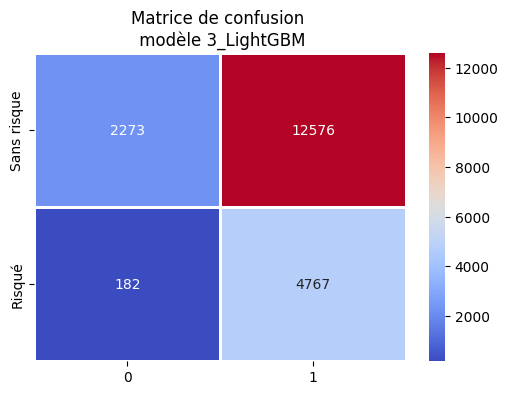

In [409]:
# Assuming 'ytest' is the true target labels and 'y_pred' are the predicted labels
cf = confusion_matrix(ytest, y_pred)
df_cm = pd.DataFrame(cf, index = [label for label in ['Sans risque', 'Risqué']],
                  columns = [i for i in "01"])


def format_confusion_matrix(value):
    return str(int(np.round(value)))
df_annot = df_cm.applymap(format_confusion_matrix)

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, cmap='coolwarm', annot=df_annot, fmt='', linewidth=1)
plt.title('Matrice de confusion \n modèle '+str(option)+'_'+model.split()[0])
plt.savefig('/content/P7_NC/CF_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png',  bbox_inches = 'tight')
mlflow.log_artifact('/content/P7_NC/CF_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png')


In [410]:
class_report = metrics.classification_report(ytest, y_pred)

print("Classification Report:")
print(class_report)
mlflow.log_text(class_report, "classification_report.txt")
mlflow.log_metrics({'score_metier' : fonction_cout(ytest, y_pred_proba[:,1])})

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.15      0.26     14849
           1       0.27      0.96      0.43      4949

    accuracy                           0.36     19798
   macro avg       0.60      0.56      0.35     19798
weighted avg       0.76      0.36      0.30     19798



## <a name="C42"> 4.2 Courbe ROC <a>

In [411]:
y_pred_proba[:, 1] #Pour chaque individus testés, la probabilités d'appartenir à la classe 1

array([0.7371245 , 0.86693634, 0.958866  , ..., 0.79569581, 0.96473406,
       0.95035799])

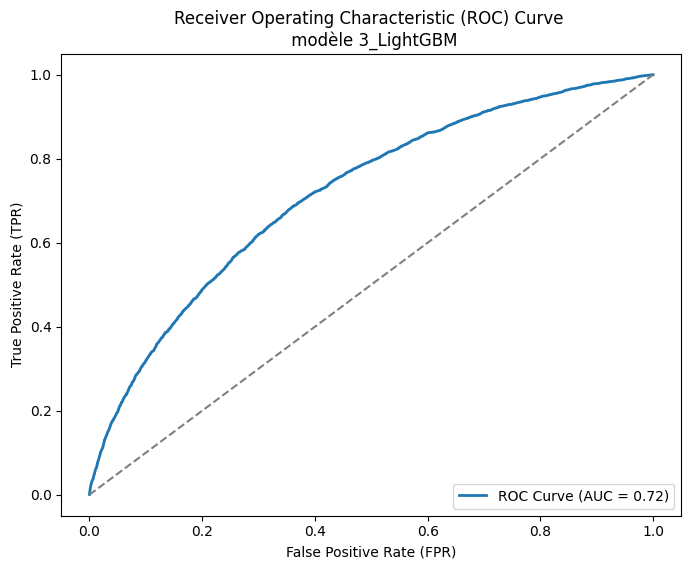

In [412]:
# Calcul de la  ROC curve
fpr, tpr, thresholds = metrics.roc_curve(ytest,y_pred_proba[:, 1], pos_label = '1')

# AUC
auc = metrics.roc_auc_score(ytest, y_pred_proba[:, 1])
mlflow.log_metrics({'AUC' : auc})

#ROC CURVE
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve \n modèle '+str(option)+'_'+model.split()[0])
plt.legend(loc='lower right')
plt.savefig('/content/P7_NC/P7_NC_ROC_CURVE'+str(option)+'_'+model.split()[0]+'.png')
mlflow.log_artifact('/content/P7_NC/P7_NC_ROC_CURVE'+str(option)+'_'+model.split()[0]+'.png')

In [413]:
mlflow.log_artifact('/content/P7_NC/P7_NC_ROC_CURVE'+str(option)+'_'+model.split()[0]+'.png')

la courbe ROC semble désigné un seuil optimal de classification à 0.42.

Dans notre cas les faux positif pour la classe 0 coûtent cher. Les prêts qu'on accorde alors qu'ils ne seront pas remboursé. On veut que la précision de la classe 1 soit la plus élevé possible.

Dans le cas du sous-échantillonage (option 1) : j'aimerais vérifier la performance du modèle validé sur les individus mis de côté. (Tous TARGET 0)

In [414]:
if (option == 1) | (option ==2):
  ind_restant = df.index.difference(ind_tot)
  #Vérification
  print(len(ind_restant) +len(ind_tot) == len(df))
  y_pred_proba_opt1 = Pipe_0.predict_proba(df.loc[ind_restant])
  y_pred_opt1 = ((y_pred_proba_opt1[:,1] >= threshold).astype(int)).astype(str)
  # Matrice de confusion
  ytest_opt1 = y_['TARGET'].loc[ind_restant]
  cf = confusion_matrix(ytest_opt1, y_pred_opt1)
  df_cm = pd.DataFrame(cf, index = [label for label in ['Sans risque', 'Risqué']],
                  columns = [i for i in "01"])
  df_annot = df_cm.applymap(format_confusion_matrix)
  plt.figure(figsize = (6,4))
  sns.heatmap(df_cm, cmap='coolwarm', annot=df_annot, fmt='', linewidth=1)
  plt.title('Matrice de confusion \n modèle '+str(option)+'_'+model.split()[0]+',dataset restant')
  plt.savefig('/content/P7_NC/CF_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'data_restant.png',  bbox_inches = 'tight')
  mlflow.log_artifact('/content/P7_NC/CF_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'data_restant.png')

In [415]:
if (option == 1) | (option ==2):
  class_report = metrics.classification_report(ytest_opt1, y_pred_opt1)
  print("Classification Report:")
  print(class_report)
  fonction_cout(ytest_opt1, y_pred_proba_opt1[:,1])
  mlflow.log_text(class_report, "classification_report_dataset_restant.txt")
  mlflow.log_metrics({'score_metier_dataset_restant' : fonction_cout(ytest, y_pred_proba[:,1])})

# <a name="C5"> 5. Feature importance </a>

In [416]:
import shap

In [417]:
models_dict[model][3]
if models_dict[model][3] == 'coeff':
  if option !=2:
    weight_feat = Pipe_0['grid_search_' + model].best_estimator_.coef_
    weight_feat
  else :
    best_estimator = Pipe_0['gridsearchcv'].best_estimator_
    weight_feat = best_estimator[id_model].coef_
    weight_feat
  new_col = X_new_transformed.columns
  feat_imp = pd.DataFrame(columns =new_col,
                        data = weight_feat)
  feat_imp.index = [model.split()[0]+'_option'+str(option)]
  feat_imp
  fig, ax = plt.subplots(figsize = (10,8))
  sns.set()
  sns.barplot(data = feat_imp, orient= 'h')
  ax.set_xlabel('\u03b8 (vecteur poids)')  # Unicode representation for theta symbol
  ax.set_ylabel('Variables')
  plt.title('Étude de feature importance pour le modèle: \n'+'Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it) )
  plt.tight_layout()  # Adjust the layout to prevent label overlapping
  plt.savefig('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png', bbox_inches = 'tight')
  mlflow.log_artifact('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png')

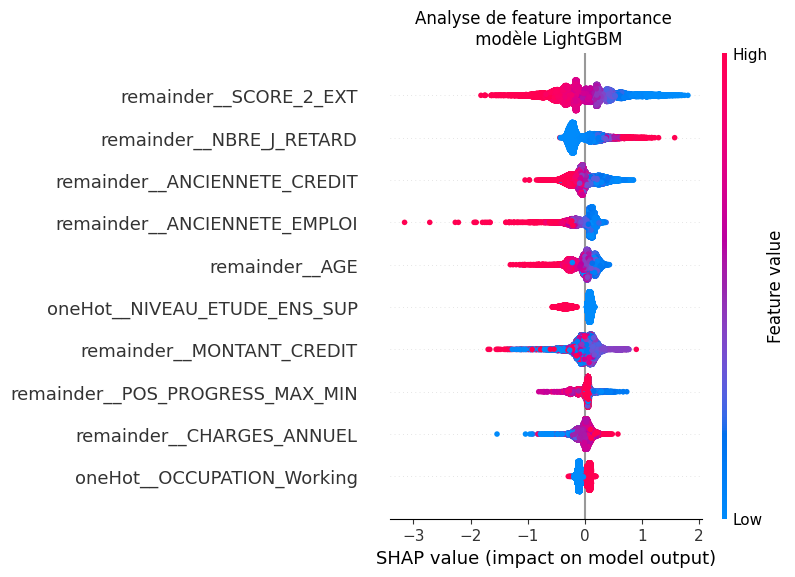

In [418]:
if models_dict[model][3] == 'shap':
  Xtest_transformed = preprocessor.transform(Xtest)
  if models_dict[model][4] == 'tree':
    if option == 2:
      explainer = shap.TreeExplainer(best_model[id_model])
    else :
      explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(Xtest_transformed)
    shap.summary_plot(shap_values[:, :, 1],  max_display=10, show = False)
    plt.title('Analyse de feature importance \n modèle '+model)
    plt.savefig('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png', bbox_inches = 'tight')

  else :
    explainer = shap.Explainer(best_model)
    shap_values = explainer.shap_values(Xtest_transformed)
    shap.plots.bar(shap_values[1], max_display=10, show = False)
    plt.title('Analyse de feature importance \n modèle '+model)
    plt.savefig('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png', bbox_inches='tight')


mlflow.log_artifact('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'.png')


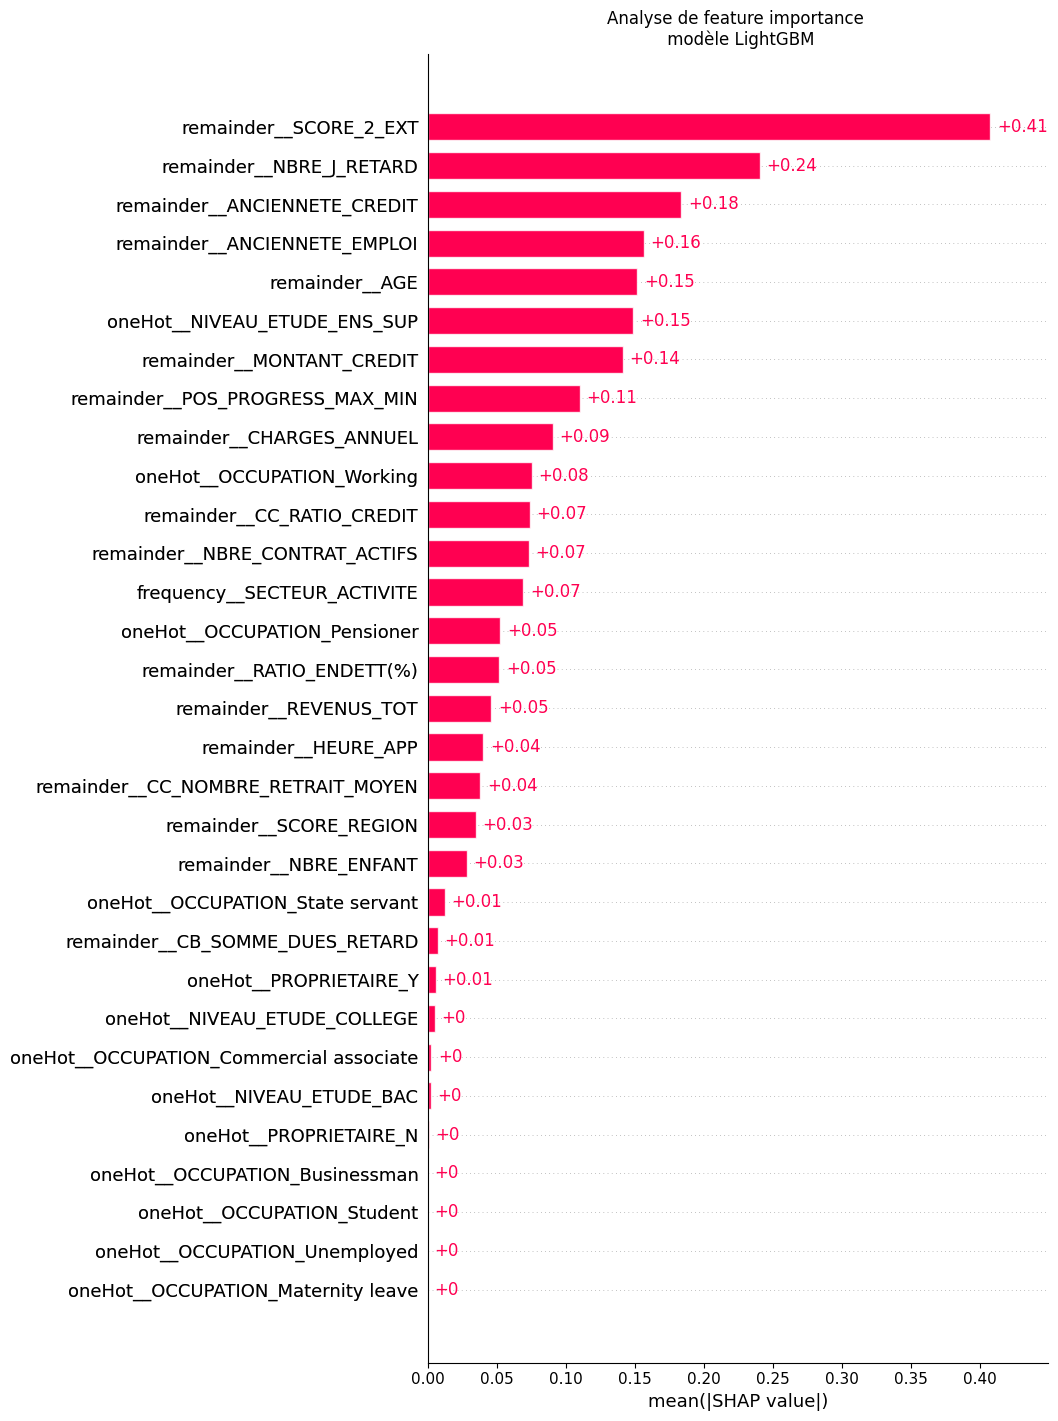

In [419]:
if models_dict[model][3] == 'shap':
  Xtest_transformed = preprocessor.transform(Xtest)
  if models_dict[model][4] == 'tree':
    if option == 2:
      explainer = shap.TreeExplainer(best_model[id_model])
    else :
      explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(Xtest_transformed)
    shap.plots.bar(shap_values[:, :, 1],  max_display=34, show = False)
    plt.title('Analyse de feature importance \n modèle '+model)
    plt.savefig('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'_bar.png', bbox_inches = 'tight')

  else :
    explainer = shap.Explainer(best_model)
    shap_values = explainer.shap_values(Xtest_transformed)
    shap.plots.bar(shap_values[1], max_display=10, show = False)
    plt.title('Analyse de feature importance \n modèle '+model)
    plt.savefig('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'_bar.png', bbox_inches='tight')


mlflow.log_artifact('/content/P7_NC/Feat_Option'+str(option)+'_'+model.split()[0]+'_itération'+str(it)+'_bar.png')

**Itération 1** :

Je choisie d'éliminer les features : REMB_ANNUEL, Je garde le one-hot encoding sur le NAME_INCOME_TYPE mais je supprimerait les features inutile : 'working', 'commercial associate'.


---

**Itération 2** :
*   Pour la logistic regression : les features les plus pertinentes sont les RATIO_ENDETT(%), NOMBRE_CONTRAT_ACTIFS, CC NOMBRE RETRAIT MOYENCB_SOMMES_DUES_RETARD, CHARGES_ANNUELLES, CC_RATIO_CREDIT.

À envisager : la suppression des features : Working, Commercial Associate.
HEURE_APP, NBRE_ENFANT, GENRE.




In [420]:
mlflow.end_run()

# <a name="C6"> 6. Traitement pour MLFlow ui  </a>

 - ## Téléchargement du meilleur modèle : LightGBM

In [107]:
import joblib

if option !=2 :
  joblib.dump(best_model, 'LightGBM_bestmodel.pkl')
else :
  joblib.dump(best_model[id_model], 'LightGBM_bestmodel.pkl')



## Modifier les fichiers meta.yaml (chemin des artifacts à modifier)

In [421]:
import os
import yaml
import shutil


# Mon chemin en local
local_folder_path = "/Users/JoycyRobert/Documents/JUPYTER/OPC/PROJET_7/P7/"

# Le chemin du dossier mlruns sur google colab
mlruns_path_on_drive = "/content/mlruns"

# Modification des chemins au sein des fichiers meta.yaml
for root, dirs, files in os.walk(mlruns_path_on_drive):
    for file in files:
        if file == "meta.yaml":
            meta_yaml_path = os.path.join(root, file)
            with open(meta_yaml_path, "r") as f:
                meta_yaml_content = yaml.safe_load(f)

            # Update 'artifact_location' if present
            if 'artifact_location' in meta_yaml_content:
                artifact_location = meta_yaml_content['artifact_location']
                # Extract the partial path from the artifact_location
                partial_path = artifact_location.split("/content/")[-1]
                # Combine with the local_folder_path to get the new artifact_location
                new_artifact_location = os.path.join(local_folder_path, partial_path)
                meta_yaml_content['artifact_location'] = new_artifact_location

            # Update 'artifact_uri' if present
            if 'artifact_uri' in meta_yaml_content:
                artifact_uri = meta_yaml_content['artifact_uri']
                # Extract the partial path from the artifact_uri
                partial_path = artifact_uri.split("/content/")[-1]
                # Combine with the local_folder_path to get the new artifact_uri
                new_artifact_uri = os.path.join(local_folder_path, partial_path)
                meta_yaml_content['artifact_uri'] = new_artifact_uri

            with open(meta_yaml_path, "w") as f:
                yaml.dump(meta_yaml_content, f)


## Téléchargement du dossier

In [422]:
import shutil

# Replace 'folder_name' with the name of the folder you want to zip
folder_name = 'mlruns'

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
from google.colab import files
files.download(f'{folder_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Suppression du dossier mlruns

In [ ]:
import shutil
import os
print(os.getcwd())
# Specify the path to the 'mlruns' directory
mlruns_directory = './mlruns'

# Delete the 'mlruns' directory and its contents
shutil.rmtree(mlruns_directory, ignore_errors=True)

#os.rmdir('/content/mlruns')

/content
